# ANÁLSIS DE LA SERIE DE TIEMPO PIB
## Oscar Julian Layton

La serie de tiempo es relativa al producto interno bruto de EEUU desde enero de 1948 hasta enero de 2008, cabe notar que las mediciones realizadas son trimestrales y están determinadas en miles de millones de dólares. Para generar un análisis respectivo a la serie y de esta manera hacer comparaciones entre los pronosticos ha de generarse la gráfica de la serie de tiempo:

Text(0.5, 1.0, 'PIB')

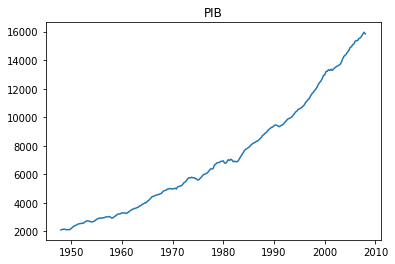

In [7]:
from pandas_datareader import DataReader     #importa unos conjuntos de datos en especial PIB
import numpy as np
import statsmodels.api as sm
import matplotlib.pylab as plt
import pandas as pd
import scipy as sp

# Obtención de los datos
start = '1948-01'
end = '2008-01'
us_gnp = DataReader('GNPC96', 'fred', start=start, end=end)
plt.plot(us_gnp);plt.title('PIB')

En correspondencia a la anterior y conociendo que que hace parte de mediciones trimestrales,  se puede observar la presencia de tendencia, no obstante para identificar estacionalidad ha de hacerse un análisis más detallado 

In [17]:
sp.stats.boxcox(us_gnp,alpha=0.05)

Observando el valor de $\lambda$ aproximadamente a cero, además los intervalos de confianza capturan a 0, en este orden de ideas se procede a realizar la transformacion logaritmo a los datos para estabilizar la varianz, en la gáfica se logra observar la serie obtenida al estabilizar la varianza.

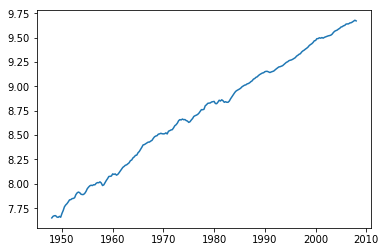

In [18]:
log_gnp = np.log(us_gnp)
dates = us_gnp.index._mpl_repr()
plt.plot(log_gnp)

Es importante considerar la prueba de Dickey Fuller para identificar la presencia o no de raiz unitaria en la serie, en este orden de ideas, al observar el p-valor de la siguiente prueba se decide no rechazar la hipotesis nula:

$H_o:$Hay presencia de raíz unitaria  v.s $H_1:$ No hay presencia de raíz unitaria 

Indicandose la necesidad de diferenciar estacionalmente la serie

In [24]:
    from statsmodels.tsa.stattools import adfuller
test1 = adfuller(log_gnp['GNPC96'], autolag='AIC')
test1
dfoutput = pd.Series(test1[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print (dfoutput)

Test Statistic                  -1.427863
p-value                          0.568848
#Lags Used                       3.000000
Number of Observations Used    237.000000
dtype: float64


Se procede a realizar el proceso basado en diferenciación ordinaria:

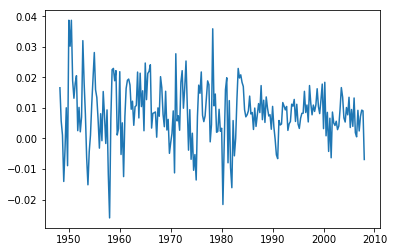

In [25]:
diford=log_gnp.diff(periods=1)   ####Diferencia Ordinaria 
plt.plot(diford)                # en esta grafica se elimina la tendencia

En la grafica anterior puede observarse el resumen del proceso de descomposicion realizado absado en diferenciación ordinaria, elcual intenta eliminar la componente de tendencia  $M_t$. No obstante al tener presencia de estacionalidad se realiza una diferencia estacional:

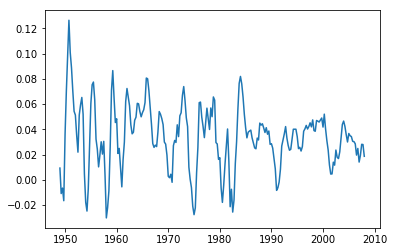

In [50]:
difest=log_gnp.diff(periods=4)    ###Diferencia Estacional
plt.plot(difest)

No obstante al observar la serie y hacer nuevamente la prueba de dickey Fuller, se rechaza $H_0$ afirmando el hecho de solo realizar una diferencia estacional. Observar la siguinete salida:


In [51]:
a=difest[12:241]
test1 = adfuller(a["GNPC96"], autolag='AIC')
test1
dfoutput = pd.Series(test1[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print (dfoutput)

Test Statistic                  -3.811731
p-value                          0.002790
#Lags Used                      14.000000
Number of Observations Used    214.000000
dtype: float64


No obstante se proecde a realizar la funcion de autocorrelación simple y parcial para identificar los ordenes máximos:

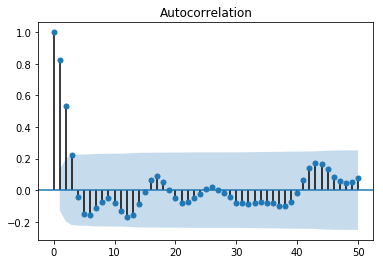

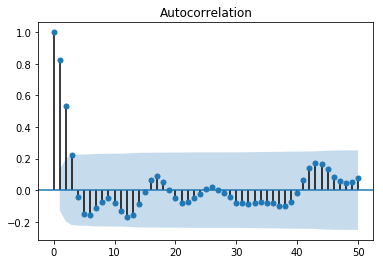

In [53]:
acf(difest[12:241],nlags=50,unbiased=False)
plot_acf(difest[12:241], lags=50, unbiased=False)

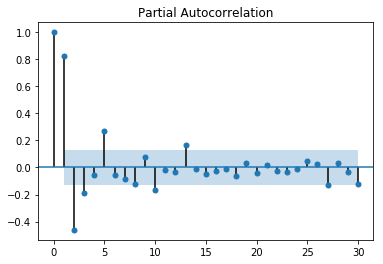

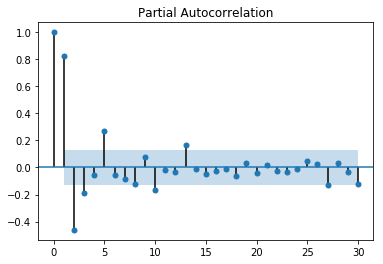

In [54]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
pacf(difest[12:241],nlags=30)
plot_pacf(difest[12:241],lags=30)

Para la componente autorregresiva se tiene p=5 y la de promedios móviles q=2. Por consiguiente se procede a realizar 

In [56]:
import statsmodels.api as smapi
modeloMASPmodel = smapi.tsa.statespace.SARIMAX(difest, trend='n', order=(5,1,2))  
####Si tiene parte estacional agregar seasonal_order=(0,0,0,12)###
results = modeloMASPmodel.fit()
print(results.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                           Statespace Model Results                           
Dep. Variable:                 GNPC96   No. Observations:                  241
Model:               SARIMAX(5, 1, 2)   Log Likelihood                 717.020
Date:                Wed, 03 Jul 2019   AIC                          -1418.041
Time:                        22:10:57   BIC                          -1390.196
Sample:                    01-01-1948   HQIC                         -1406.821
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2697      0.153      1.759      0.079      -0.031       0.570
ar.L2         -0.2597      0.078     -3.338      0.001      -0.412      -0.107
ar.L3          0.1704      0.077      2.222      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 A continuación, veamos cómo podemos usar el modelo ARIMA para hacer pronósticos.

,lower GNPC96,upper GNPC96
2008-04-01,0.006310,0.021684
2008-07-01,-0.010414,0.014862
2008-10-01,-0.019098,0.016811
2009-01-01,-0.017554,0.028215


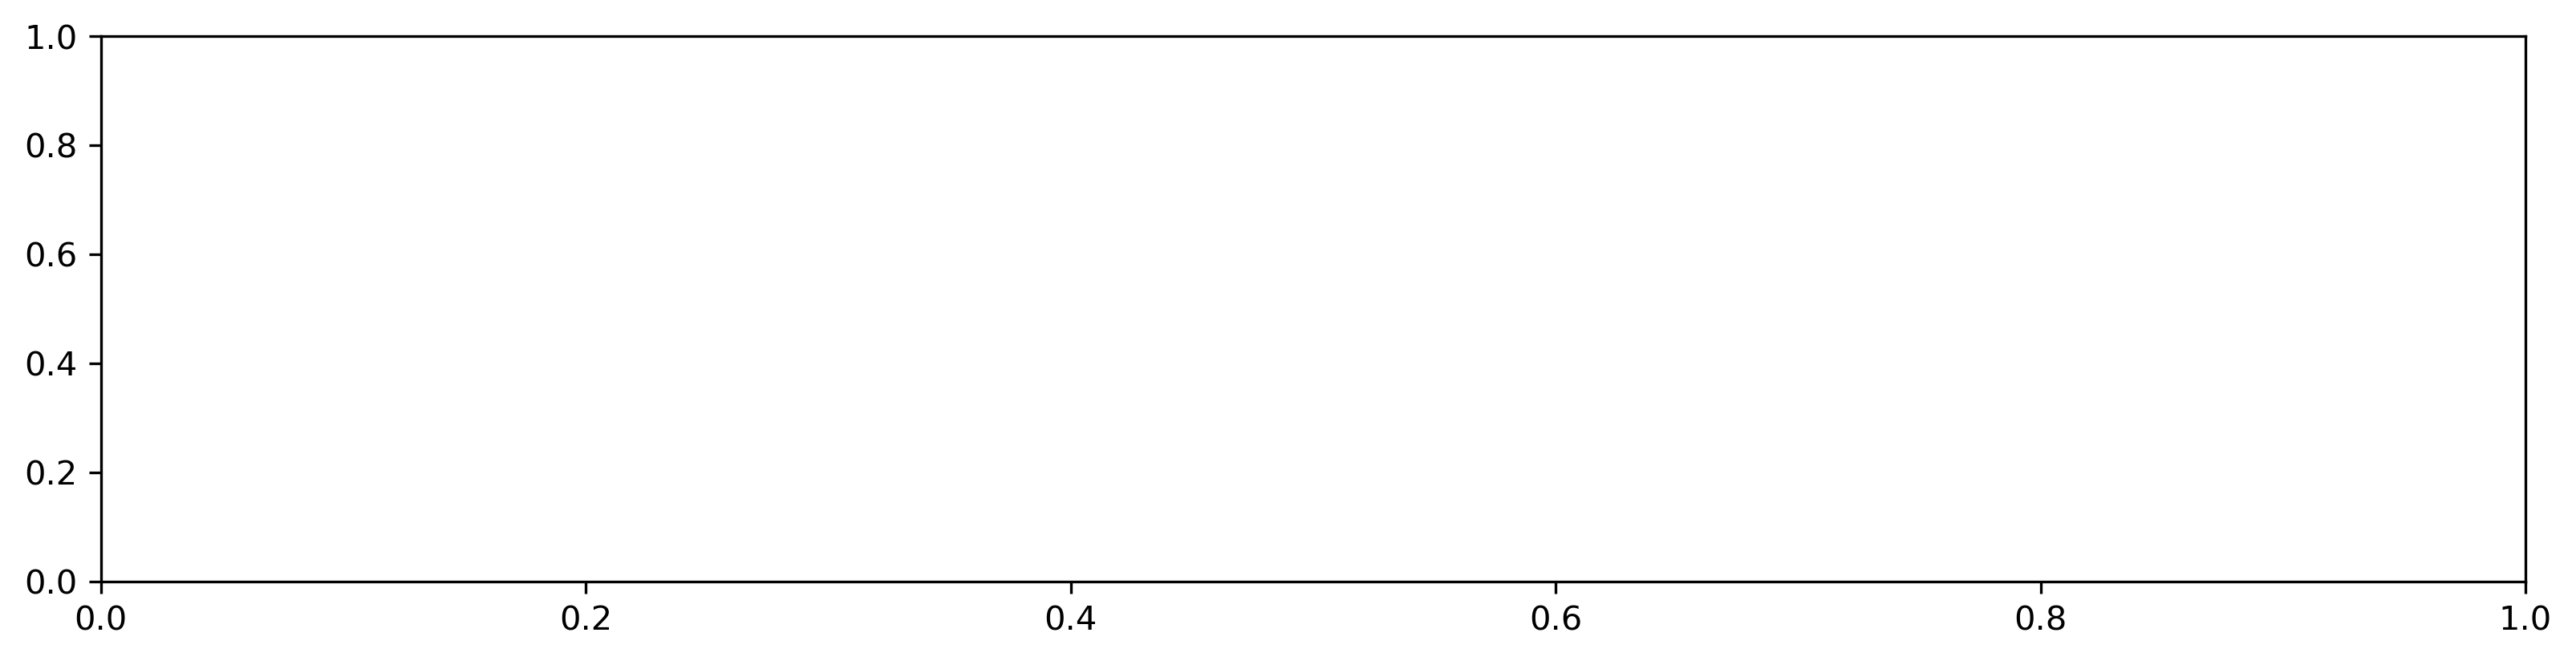

In [77]:
results.forecast(12)  #pronosticos en escala logaritmica en 12 periodos hacia adelante
log_gnp_forecast=results.get_prediction(start='2008-04-01', end='2009-01-01') 
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
forecast = log_gnp_forecast.predicted_mean
forecast      #pronosticos para los sig 4 periodos (1 año) !!estan EN ESCALA LOGARITMICA!
ci = log_gnp_forecast.conf_int(alpha=0.5)
ci


No obstante los pronosticos por el método ARIMA son proporcionados en escala logaritmica, luego se procede a realizar la transfomacion inversa Box cox y en consecuencia graficar los pronosticos:

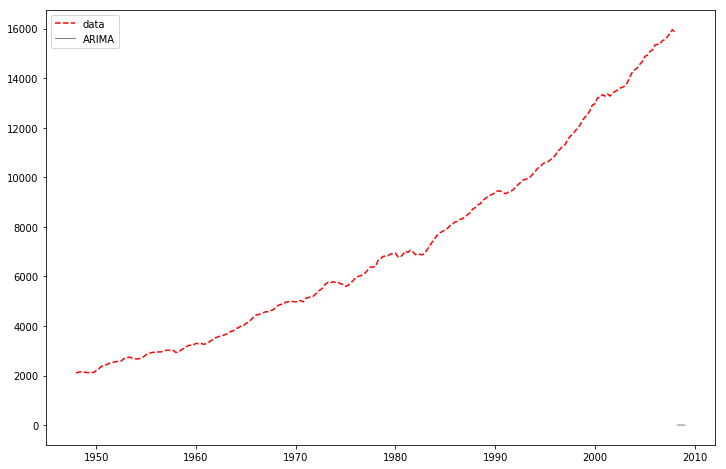

In [79]:
#desde aqui nos permitee volvernos a la escala original por medio de trasns boxcox inversa
arraypronosticosSTIC={'pronostico':forecast.values,'li':ci['lower GNPC96'].values,'ls':ci['upper GNPC96'].values}  #el valor del pronostico en la escala original que son
indice=pd.date_range(start='2008-04-01',end='2009-01-01',freq='QS')
pronosticosSTIC=pd.DataFrame(data=arraypronosticosSTIC,index=indice)   #PRONOSTICOS E INTERVALOS DE CONFIANZA
 
#####Función inversa Box-Cox######
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)



for column in ['pronostico', 'li', 'ls']:
    pronosticosSTIC[column] = inverse_boxcox(pronosticosSTIC[column],0)  #antes estaba pronosticosSTIC[column] y no se veia nada
    
    #%%#
#######Gráfica de los pronósticos#####
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
#Actual data
ax.plot(us_gnp.astype('float64'), '--', color="red", label='data')   #colocando etiquetas
# Means
ax.plot(pronosticosSTIC['pronostico'], lw=1, color="black", alpha=0.5, label='ARIMA') #colocando etiquetas
ax.fill_between(pronosticosSTIC['pronostico'].index, pronosticosSTIC.iloc[:, 1], pronosticosSTIC.iloc[:, 2], alpha=0.05)
ax.legend(loc='upper left')
plt.draw()

### POR MEDIO DEL MODELO ESTRUCTURAL

Se procede a estimar cada una de las componentes por medio de las siguientes líneas, no obstante ha de considerarse que la estadística z y el pvalor no tienen algun significado dentro del proceso:

In [74]:
unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

output_mod = sm.tsa.UnobservedComponents(log_gnp, **unrestricted_model)  
output_res = output_mod.fit(method='powell', disp=False)   #estimacion de cada una de las componentes
print(output_res.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


                            Unobserved Components Results                            
Dep. Variable:                        GNPC96   No. Observations:                  241
Model:                    local linear trend   Log Likelihood                 769.632
                   + damped stochastic cycle   AIC                          -1527.264
Date:                       Wed, 03 Jul 2019   BIC                          -1506.455
Time:                               22:52:00   HQIC                         -1518.877
Sample:                           01-01-1948                                         
                                - 01-01-2008                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   1.09e-06   7.29e-06      0.150      0

Ahora bien, se presenta la grafica de las estimaciones de las componentes intramuestras de cada una de las componentes de modelo esructural, tendencia, level (2 y 3 gráfica),  la componente ciclica en la cuarta gráfica. Cabe aclarar que en la componente ciclica aparece arriba la prediccion y las predicciones intramuestra un paso adelante donde una esta encima de la otra. Además los residuales no los genera el procedimiento, solo hay que hallarlos por medio de lo observado menos lo estimado.

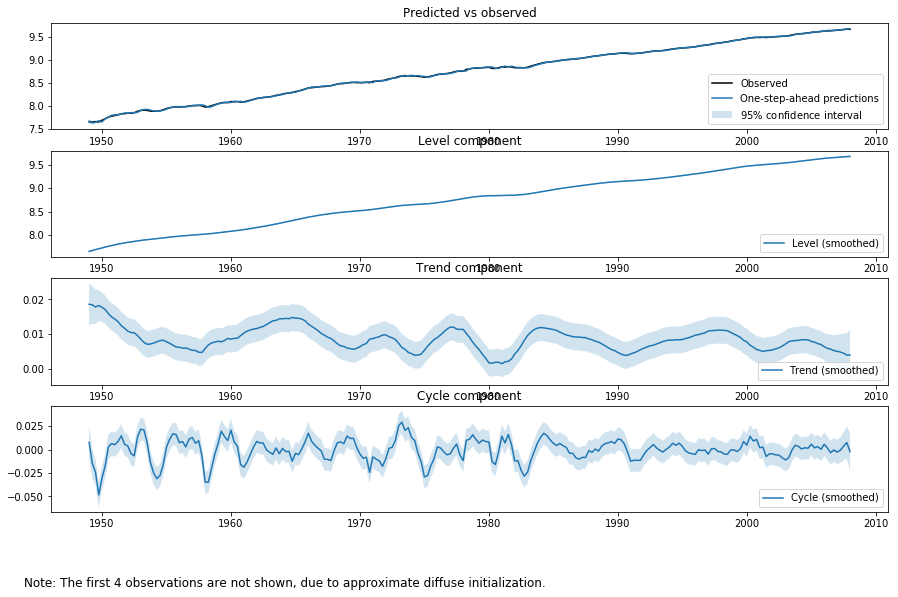

In [61]:
fig = output_res.plot_components(legend_loc='lower right', figsize=(15, 9)); 

No obstante se presentan los pronósticos en escala logarítmica 4 periodos hacia adelante.

,lower GNPC96,upper GNPC96
2008-04-01,9.667343,9.679859
2008-07-01,9.666744,9.687699
2008-10-01,9.667205,9.696144
2009-01-01,9.668506,9.704842


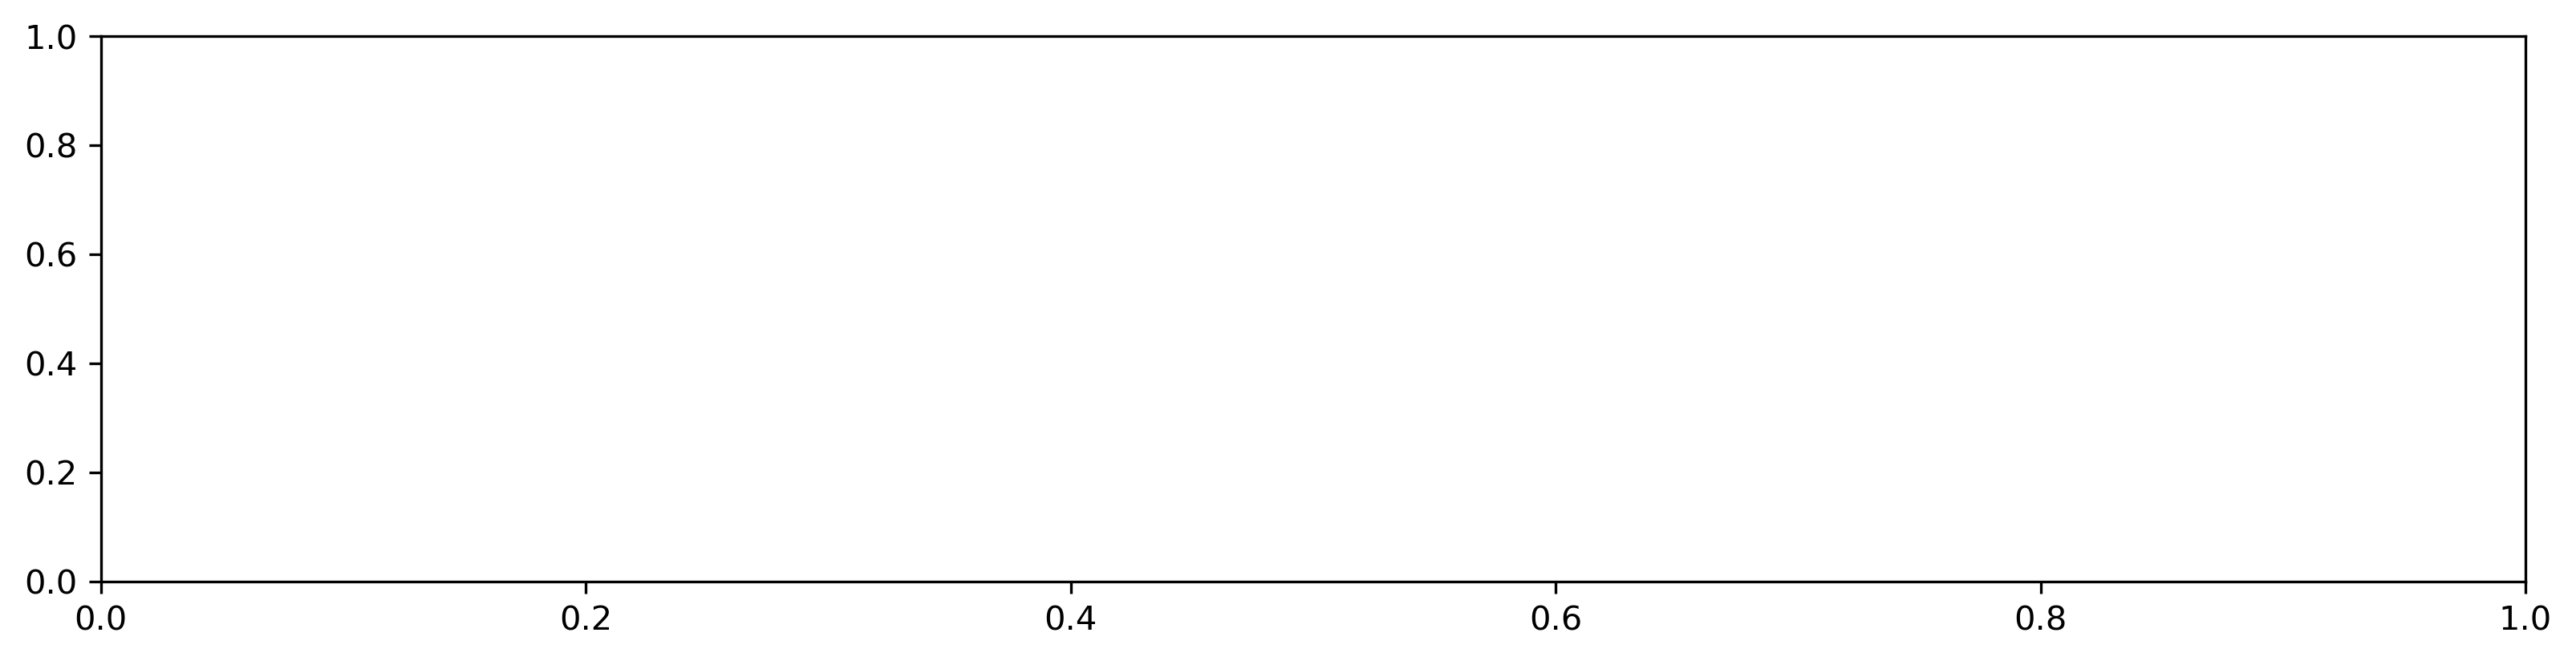

In [71]:
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
forecast = log_gnp_forecast.predicted_mean
forecast      #pronosticos para los sig 4 periodos (1 año) !!estan EN ESCALA LOGARITMICA!
ci = log_gnp_forecast.conf_int(alpha=0.5)
ci

Hay que considerar que los pronosticos se encuentran en la escala logaritmica, luego hay que realizarse una transformación Box-Cox inversa para generar análisis desde la escala original.

In [72]:
arraypronosticosSTIC={'pronostico':forecast.values,'li':ci['lower GNPC96'].values,'ls':ci['upper GNPC96'].values}  #el valor del pronostico en la escala original que son
indice=pd.date_range(start='2008-04-01',end='2009-01-01',freq='QS')
pronosticosSTIC=pd.DataFrame(data=arraypronosticosSTIC,index=indice)   #PRONOSTICOS E INTERVALOS DE CONFIANZA
 
#####Función inversa Box-Cox######
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)



####Se devuelve  a la escala original
for column in ['pronostico', 'li', 'ls']:
    pronosticosSTIC[column] = inverse_boxcox(pronosticosSTIC[column],0)  #antes estaba pronosticosSTIC[column] y no se veia nada
    

Por consiguiente, la gráfica de los pronósticos está determinada por las siguientes líneas, mostrándose los pronósticos generados anteriormente.

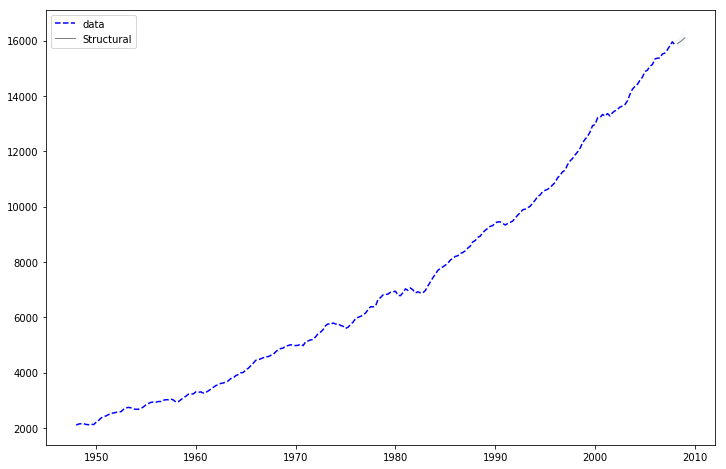

In [73]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
#Actual data
ax.plot(us_gnp.astype('float64'), '--', color="blue", label='data')   #colocando etiquetas
# Means
ax.plot(pronosticosSTIC['pronostico'], lw=1, color="black", alpha=0.5, label='Structural') #colocando etiquetas
ax.fill_between(pronosticosSTIC['pronostico'].index, pronosticosSTIC.iloc[:, 1], pronosticosSTIC.iloc[:, 2], alpha=0.05)
ax.legend(loc='upper left')
plt.draw()

Finalmente para realizar pronosticos por medio de Rolling se tiene:

In [80]:
from sklearn.metrics import mean_squared_error

X = log_gnp.values  #valores de mi serie
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]  #dividiendo mi serie en terminos de entrenamiento y prueba
history = [x for x in train]
predicciones = list()
for t in range(len(test)):
	output_mod = sm.tsa.UnobservedComponents(history, **unrestricted_model)
	modelo_fit = output_mod.fit(method='powell', disp=False)
	output = modelo_fit.forecast()  ####Especificar los pasos adelante
	yhat = output[0]
	predicciones.append(np.exp(yhat))
	obs = test[t]
	history.append(obs)
	print('Predicción=%f, Esperado=%f' % (np.exp(yhat), np.exp(obs)))
error = mean_squared_error(np.exp(test), predicciones)
print('ECM: %.3f' % error)


Predicción=10872.096413, Esperado=10872.421000
Predicción=10966.732047, Esperado=11041.392000
Predicción=11165.399923, Esperado=11135.535000
Predicción=11237.691864, Esperado=11258.169000
Predicción=11364.603807, Esperado=11319.212000
Predicción=11403.487519, Esperado=11516.945000
Predicción=11641.129942, Esperado=11650.143000
Predicción=11767.356918, Esperado=11740.681000
Predicción=11842.693386, Esperado=11869.712000
Predicción=11979.972997, Esperado=11975.231000
Predicción=12094.306351, Esperado=12107.382000
Predicción=12226.947611, Esperado=12306.035000
Predicción=12457.520911, Esperado=12434.656000
Predicción=12573.720336, Esperado=12536.319000
Predicción=12660.147893, Esperado=12695.786000
Predicción=12834.830886, Esperado=12923.768000
Predicción=13089.351577, Esperado=12965.481000
Predicción=13087.320819, Esperado=13205.975000
Predicción=13375.202754, Esperado=13217.516000
Predicción=13330.354177, Esperado=13330.887000
Predicción=13456.140729, Esperado=13274.505000
Predicción=13

NameError: name 'pyplot' is not defined

Se crea un gráfico de líneas que muestra los valores esperados (azul) en comparación con las predicciones de pronóstico continuo (rojo). Podemos ver que los valores muestran alguna tendencia y están en la escala correcta.



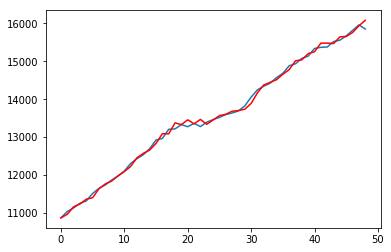

In [82]:
plt.plot(np.exp(test))
plt.plot(predicciones, color='red')
plt.show()